Notebook to analyse the data regarding the aggregate SBP adoption before 2008 and the one during the Portuguese Carbon Fund project (PCF project) and merging them into a dataset reporting the SBP adoption from 1996 to 2012.

**Requirements**: numpy pandas xlrd openpyxl

## Content
* PCF project: retrieve adoption over each municipality
* Merge of adoption previous and during PCF -> Yearly SBP adoption per municipality
* Other datasets construction:
    * Cumulative adoption in each year
    * Yearly and cumulative for Portugal
    * Adoption in neighbours
* Datasets merging for machine learning models
* Create datasets with relative values of adoption refferd to permanent pasture area
    * Create and save dataset with % adoption in munic for ABM initialisation
    * Save datasets for ABM validation

In [188]:
import numpy as np
import pandas as pd

# Data ingestion and manipulation

In [189]:
path_to_PCF_data = "./PCF project data_Corrected counties.xlsx"
path_to_adoption_pre_PCF = "./SBP adoption previous to 2009 per municipality_PCF mapped.xlsx"

In [190]:
out_file = "./Final SBP adoption datasets/SBP yearly adoption + adoption features_PCF mapped.csv"
out_path_adoption_percentage = "./Final SBP adoption datasets/SBP % yearly adoption + % adoption features_PCF mapped.csv"

## PCF project

In [191]:
PCF_data = pd.read_excel(path_to_PCF_data, index_col=0)
PCF_data.head()

,Farmer_ID,Year that the pasture was installed,County,Area_Total_SIG_PPI_2009_ha,Area_Total_SIG_PPI_2010_ha,Area_Total_SIG_PPII_2011_ha,Area_Total_SIG_PPII_2012_ha
Parcel_ID,,,,,,,
55,1,2009,Idanha-a-Nova,9.28,0.00,0.00,0.00
410,2,2010,Évora,0.00,3.21,0.00,0.00
681,2,2011,Évora,0.00,0.00,6.83,0.00
1068,3,2012,Reguengos de Monsaraz,0.00,0.00,0.00,38.17
584,4,2010,Avis,0.00,9.57,0.00,0.00


In [192]:
PCF_data = PCF_data.drop('Farmer_ID', axis=1)

In [193]:
PCF_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 55 to 1048
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year that the pasture was installed  1113 non-null   int64  
 1   County                               1113 non-null   object 
 2   Area_Total_SIG_PPI_2009_ha           1113 non-null   float64
 3   Area_Total_SIG_PPI_2010_ha           1113 non-null   float64
 4   Area_Total_SIG_PPII_2011_ha          1113 non-null   float64
 5   Area_Total_SIG_PPII_2012_ha          1113 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 60.9+ KB


### Check years have only values from 2009 to 2014

In [194]:
PCF_data['Year that the pasture was installed'].value_counts()

2010    310
2012    289
2009    279
2011    235
Name: Year that the pasture was installed, dtype: int64

### Check if any parcel adopted in multiple years, i.e. if any has two non zero values in the total area adopted each year

In [195]:
cols_with_area = ['Area_Total_SIG_PPI_2009_ha', 
                 'Area_Total_SIG_PPI_2010_ha', 
                 'Area_Total_SIG_PPII_2011_ha', 
                 'Area_Total_SIG_PPII_2012_ha']

number_of_year_adopted = len(cols_with_area) - (PCF_data[cols_with_area] == 0).sum(axis=1)

In [196]:
adopted_1_year = number_of_year_adopted == 1
all(adopted_1_year)

False

In [197]:
# Number of parcels which have correctly one adoption
sum(adopted_1_year)

1100

In [198]:
adopted_0_years = number_of_year_adopted == 0
sum(adopted_0_years)

13

Therefore, there are 1100 for which we have the area adopted and 13 for which we have not data on the area adopted that we can exclude.

In [199]:
parcels_without_adoption = PCF_data[adopted_0_years]
parcels_without_adoption.head()

,Year that the pasture was installed,County,Area_Total_SIG_PPI_2009_ha,Area_Total_SIG_PPI_2010_ha,Area_Total_SIG_PPII_2011_ha,Area_Total_SIG_PPII_2012_ha
Parcel_ID,,,,,,
414,2010,Évora,0.0,0.0,0.0,0.0
359,2010,Alcácer do Sal,0.0,0.0,0.0,0.0
106,2009,Arraiolos,0.0,0.0,0.0,0.0
249,2009,Alter do Chão,0.0,0.0,0.0,0.0
1061,2012,Vila Viçosa,0.0,0.0,0.0,0.0


In [200]:
PCF_data = PCF_data.drop(parcels_without_adoption.index)

In [201]:
len(PCF_data)

1100

Since each parcel adopted in one year and the DataFrame has a column for the year of adoption, we can substitute the last columns with the area of adoption with just one columns having the area adopted in any year.

In [202]:
PCF_data[cols_with_area].max(axis=1)
PCF_data['Area'] = PCF_data[cols_with_area].max(axis=1)

In [203]:
PCF_data = PCF_data.drop(cols_with_area, axis=1)

In [204]:
PCF_data.head()

,Year that the pasture was installed,County,Area
Parcel_ID,,,
55,2009,Idanha-a-Nova,9.28
410,2010,Évora,3.21
681,2011,Évora,6.83
1068,2012,Reguengos de Monsaraz,38.17
584,2010,Avis,9.57


### Get municipality adoption per municipality, per year

In [205]:
munic_adoption_MI = PCF_data.groupby(['County', 'Year that the pasture was installed']).sum()
munic_adoption_MI.head()

Area
County    Year that the pasture was installed        
Abrantes  2009                                  67.24
          2010                                 241.73
          2011                                  52.38
          2012                                 156.63
Alandroal 2009                                 205.70

Rearrange to have the years as a columns and bring in the same format as the SBP adoption previous to the PCF project

In [206]:
munic_adoption_PCF = munic_adoption_MI.unstack(fill_value=0)
munic_adoption_PCF.head()

Area                         
Year that the pasture was installed     2009     2010    2011    2012
County                                                               
Abrantes                               67.24   241.73   52.38  156.63
Alandroal                             205.70   557.06  167.75  934.91
Alcochete                               0.00   347.12  238.65  348.91
Alcácer do Sal                       1084.30  1112.69  720.92  644.67
Alenquer                                0.00     0.00   14.66    0.00

In [207]:
munic_adoption_PCF.columns.names = (None, None)
munic_adoption_PCF.head()

Area                         
                   2009     2010    2011    2012
County                                          
Abrantes          67.24   241.73   52.38  156.63
Alandroal        205.70   557.06  167.75  934.91
Alcochete          0.00   347.12  238.65  348.91
Alcácer do Sal  1084.30  1112.69  720.92  644.67
Alenquer           0.00     0.00   14.66    0.00

In [208]:
munic_adoption_PCF.index.name = 'Municipality'

In [209]:
munic_adoption_PCF.columns = munic_adoption_PCF.columns.droplevel()
munic_adoption_PCF.head()

,2009,2010,2011,2012
Municipality,,,,
Abrantes,67.24,241.73,52.38,156.63
Alandroal,205.70,557.06,167.75,934.91
Alcochete,0.00,347.12,238.65,348.91
Alcácer do Sal,1084.30,1112.69,720.92,644.67
Alenquer,0.00,0.00,14.66,0.00


In [210]:
len(munic_adoption_PCF)

73

#### Retrieve list of municipalities which adopted during the PCF project

In [211]:
munic_adoption_PCF_list = munic_adoption_PCF.index.tolist()

In [212]:
import csv

with open("list_of_munic_that_adopted_during_PCF.csv", "w+") as file:
    wr = csv.writer(file)
    wr.writerow(munic_adoption_PCF_list)

## SBP adoption previous to the PCF project

In [213]:
munic_adoption_pre_PCF = pd.read_excel(path_to_adoption_pre_PCF, index_col=0)
munic_adoption_pre_PCF

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
Municipality,,,,,,,,,,,,,
Arouca,0.000000,2.457613,2.048011,0.000000,1.228806,0.000000,4.096022,12.288065,15.155280,14.336076,14.745678,56.525099,20.480108
Castelo de Paiva,0.000000,0.059363,0.049469,0.000000,0.029681,0.000000,0.098938,0.296813,0.366070,0.346282,0.356176,1.365341,0.494689
Espinho,0.000000,0.004374,0.003645,0.000000,0.002187,0.000000,0.007290,0.021870,0.026974,0.025516,0.026245,0.100604,0.036451
Santa Maria da Feira,0.000000,0.040617,0.033847,0.000000,0.020308,0.000000,0.067694,0.203083,0.250469,0.236930,0.243699,0.934180,0.338471
Oliveira de Azeméis,0.000000,0.068736,0.057280,0.000000,0.034368,0.000000,0.114559,0.343678,0.423870,0.400958,0.412414,1.580921,0.572797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
São Brás de Alportel,0.058552,0.035131,0.070262,0.070262,0.298613,0.158089,0.035131,0.058552,0.035131,0.087827,0.234206,0.286902,0.005855
Silves,1.531348,0.918809,1.837617,1.837617,7.809873,4.134638,0.918809,1.531348,0.918809,2.297021,6.125390,7.503603,0.153135
Tavira,0.580110,0.348066,0.696133,0.696133,2.958564,1.566298,0.348066,0.580110,0.348066,0.870166,2.320442,2.842541,0.058011


In [214]:
len(munic_adoption_pre_PCF)

278

# Municipalities comparison 

In [215]:
munic_PCF = munic_adoption_PCF.index.tolist()
munic_pre_PCF = munic_adoption_pre_PCF.index.tolist()

In [216]:
munic_in_PCF_not_in_prePCF = [munic for munic in munic_PCF if munic not in munic_pre_PCF]
munic_in_PCF_not_in_prePCF

[]

In [217]:
munic_in_prePCF_not_in_PCF = [munic for munic in munic_pre_PCF if munic not in munic_PCF]
len(munic_in_prePCF_not_in_PCF)

205

## Dataset merging

In [218]:
munic_adoption = pd.concat([munic_adoption_pre_PCF, munic_adoption_PCF], axis=1)

In [219]:
munic_adoption[munic_adoption.isna()] = 0

In [220]:
munic_adoption.index.name = 'Municipality'

Add a columns for 1995 with all 0s, since adoption values in 1995 serves to predict the adoption in 1996.

In [221]:
munic_adoption.insert(0, 1995, 0)

## Save dataset

In [222]:
file_munic_adoption = "./Final SBP adoption datasets/Yearly SBP adoption per municipality.xlsx"

In [223]:
munic_adoption.to_excel(file_munic_adoption)

# Other datasets construction

## Cumulative SBP adoption per municipality

In [224]:
cumulative_total_munic_adoption = munic_adoption.cumsum(axis=1)
cumulative_total_munic_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Municipality,,,,,,,,,,,,,,,,,,
Arouca,0.0,0.000000,2.457613,4.505624,4.505624,5.734430,5.734430,9.830452,22.118517,37.273797,51.609873,66.355551,122.880650,143.360758,143.360758,143.360758,143.360758,143.360758
Castelo de Paiva,0.0,0.000000,0.059363,0.108831,0.108831,0.138513,0.138513,0.237451,0.534264,0.900333,1.246615,1.602791,2.968132,3.462820,3.462820,3.462820,3.462820,3.462820
Espinho,0.0,0.000000,0.004374,0.008019,0.008019,0.010206,0.010206,0.017496,0.039367,0.066340,0.091856,0.118100,0.218704,0.255155,0.255155,0.255155,0.255155,0.255155
Santa Maria da Feira,0.0,0.000000,0.040617,0.074464,0.074464,0.094772,0.094772,0.162466,0.365549,0.616017,0.852947,1.096647,2.030827,2.369298,2.369298,2.369298,2.369298,2.369298
Oliveira de Azeméis,0.0,0.000000,0.068736,0.126015,0.126015,0.160383,0.160383,0.274943,0.618621,1.042491,1.443449,1.855863,3.436784,4.009581,4.009581,4.009581,4.009581,4.009581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
São Brás de Alportel,0.0,0.058552,0.093682,0.163944,0.234206,0.532819,0.690908,0.726039,0.784590,0.819721,0.907549,1.141755,1.428657,1.434512,1.434512,1.434512,1.434512,1.434512
Silves,0.0,1.531348,2.450156,4.287773,6.125390,13.935263,18.069902,18.988710,20.520058,21.438866,23.735888,29.861278,37.364881,37.518016,37.518016,37.518016,37.518016,37.518016
Tavira,0.0,0.580110,0.928177,1.624309,2.320442,5.279006,6.845304,7.193370,7.773481,8.121547,8.991713,11.312155,14.154696,14.212707,14.212707,14.212707,14.212707,14.212707


Save file

## Datasets for Portugal

Dataset reporting for Portugal both the yearly adoption and the cumulative adoption

In [225]:
portugal_adoption = pd.DataFrame(columns=cumulative_total_munic_adoption.columns)

In [226]:
portugal_adoption.loc['Yearly adoption'] = munic_adoption.sum()
portugal_adoption.loc['Total cumulative adoption'] = cumulative_total_munic_adoption.sum()

In [227]:
portugal_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Yearly adoption,0.0,1682.0,1953.5,3968.0,3930.5,3922.5,5327.0,7839.0,10789.0,12419.0,8081.0,7431.0,9993.0,5967.0,12585.72,15485.48,9571.6,14136.67
Total cumulative adoption,0.0,1682.0,3635.5,7603.5,11534.0,15456.5,20783.5,28622.5,39411.5,51830.5,59911.5,67342.5,77335.5,83302.5,95888.22,111373.70,120945.3,135081.97


Save file

<AxesSubplot:>

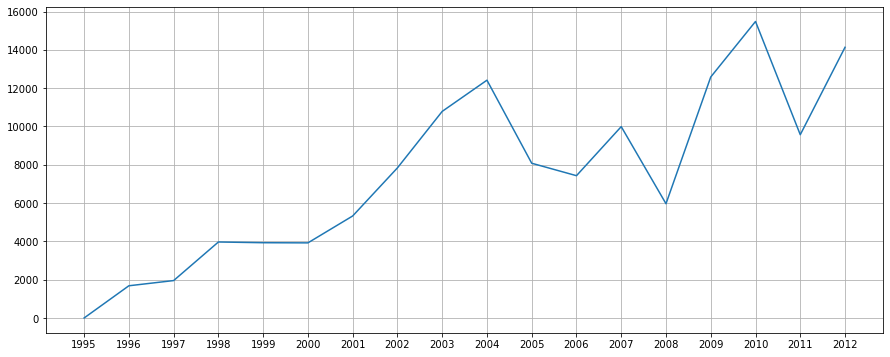

In [228]:
portugal_adoption.loc['Yearly adoption'].plot(figsize=(15,6), xticks=portugal_adoption.columns, grid=True)

# Datasets merging for machine learning models

To train the machine learnig models, we need a dataset having one row for each municipality for each year. The label is the adoption in that year. The features are all the datasets contructed above and refer to the previous year.

In [229]:
def multiindex_from_dataframe_columns(df, col_name, previous_year=False):
    """
    Function to create a multiindex from a dataframe, with the columns of the dataframe becoming the second level of the 
    multiindex.
    """
    keys = df.index.tolist()
    years = [y for y in df.columns.tolist() if y !=1995]
    mi = pd.MultiIndex.from_product([keys, years])
    mi = mi.to_frame()
    mi.drop(mi.columns, axis=1, inplace=True)
    for key in keys:
        for year in years:
            if previous_year:
                mi.loc[(key, year), col_name] = df.loc[key, year-1]
            else:
                mi.loc[(key, year), col_name] = df.loc[key, year]
    return mi

In [230]:
labels = multiindex_from_dataframe_columns(munic_adoption, 'adoption_in_year')

## Add features

### Total cumulative adoption previous year municipality

The cumulative adoptions are including the year of the columns, therefore need to be added considering this (previous_year=True)

In [231]:
tot_cum_adoption_previous_year_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption,
                                                                        'tot_cumul_adoption_pr_y_munic',
                                                                        previous_year=True)

### Concatenate datasets with yearly values

In [232]:
datasets = [labels, tot_cum_adoption_previous_year_munic]

In [233]:
SBP_adoption_final = pd.concat(datasets, axis=1)

In [234]:
SBP_adoption_final.index.rename(['Municipality', 'Year'], inplace=True)

### Add Portugal cumulative adoption until the previous year

In [235]:
from itertools import cycle

def add_col_depending_on_year_not_on_munic(final_dataset, df_rows_to_append, cols_names):
    values = df_rows_to_append.transpose().to_numpy()
    values = np.reshape(values, (len(values), 1))
    yearly_values = cycle(values)
    final_dataset[cols_names] = [next(yearly_values) for i in range(len(final_dataset))]

In [237]:
cols_to_append = portugal_adoption.loc['Total cumulative adoption', 1995:2011]
cols_names = ['tot_cumul_adoption_pr_y_port']

add_col_depending_on_year_not_on_munic(SBP_adoption_final, cols_to_append, cols_names)

## Remove São João da Madeira (since no permanent pastures)

In [238]:
to_drop = ['São João da Madeira']
SBP_adoption_final.drop(to_drop, level='Municipality', inplace=True)

# Save final dataset

In [239]:
SBP_adoption_final.head(17)

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Arouca       1996          0.000000                       0.000000   
             1997          2.457613                       0.000000   
             1998          2.048011                       2.457613   
             1999          0.000000                       4.505624   
             2000          1.228806                       4.505624   
             2001          0.000000                       5.734430   
             2002          4.096022                       5.734430   
             2003         12.288065                       9.830452   
             2004         15.155280                      22.118517   
             2005         14.336076                      37.273797   
             2006         14.745678                      51.609873   
             2007         56.525099                      66.355551   
             2008         20.480108                     122.880650   
             2009          0.000000                     143.360758   
             2010          0.000000                     143.360758   
             2011          0.000000                     143.360758   
             2012          0.000000                     143.360758   

                   tot_cumul_adoption_pr_y_port  
Municipality Year                                
Arouca       1996                          0.00  
             1997                       1682.00  
             1998                       3635.50  
             1999                       7603.50  
             2000                      11534.00  
             2001                      15456.50  
             2002                      20783.50  
             2003                      28622.50  
             2004                      39411.50  
             2005                      51830.50  
             2006                      59911.50  
             2007                      67342.50  
             2008                      77335.50  
             2009                      83302.50  
             2010                      95888.22  
             2011                     111373.70  
             2012                     120945.30

In [240]:
SBP_adoption_final.to_csv(out_file)

# Create datasets with relative values of adoption referred to permanent pastures area

In [243]:
path_to_pasture_area = "../census/extracted/municipalities_reference_permanent_pastures_area.csv"

In [244]:
pasture_area_munic = pd.read_csv(path_to_pasture_area, index_col='Municipality')

In [245]:
pasture_area_munic.head(2)

,pastures_area_munic_ha
Municipality,
Arouca,2602.0
Castelo de Paiva,74.0


In [246]:
cols = SBP_adoption_final.columns

In [247]:
SBP_perc_adoption_final = pd.DataFrame(index=SBP_adoption_final.index, columns=cols)

### Create and save dataset with % adoption in munic for ABM

In [248]:
munic_perc_yearly_adoption = munic_adoption.divide(
    pasture_area_munic['pastures_area_munic_ha'], axis=0, level='Municipality'
)

In [249]:
munic_perc_yearly_adoption[2013] = 0.
munic_perc_yearly_adoption[2014] = 0.

In [250]:
out_path_munic_perc_yearly_adoption = "./Final SBP adoption datasets/% yearly SBP adoption per municipality.csv"

In [251]:
munic_perc_yearly_adoption.to_csv(out_path_munic_perc_yearly_adoption)

### Add columns on single municipality

In [254]:
cols_munic = ['adoption_in_year', 'tot_cumul_adoption_pr_y_munic']

In [255]:
SBP_perc_adoption_final[cols_munic] = SBP_adoption_final[cols_munic].divide(
    pasture_area_munic['pastures_area_munic_ha'], axis=0, level='Municipality'
)

Checks

In [256]:
all(SBP_perc_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] == (
    SBP_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] / pasture_area_munic.loc['Grândola'].values
))

True

In [257]:
#Any NaN?
SBP_perc_adoption_final[SBP_perc_adoption_final[cols_munic].isnull().any(axis=1)].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

### Add columns for Portugal

In [258]:
pasture_area_port = sum(pasture_area_munic['pastures_area_munic_ha'])

In [259]:
cols_port = [col for col in cols if 'port' in col]

In [260]:
SBP_perc_adoption_final[cols_port] = SBP_adoption_final[cols_port].divide(
    pasture_area_port, axis=0, level='Municipality'
)

Checks

In [261]:
all(SBP_perc_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] == (
    SBP_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] / pasture_area_port
))

True

#### Final check: are there values over 1?

In [262]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 1].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

No more values over 1

In [263]:
rows_over_1 = SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 1]
munic_over_1 = rows_over_1.index.get_level_values(0).unique().to_list()
munic_over_1

[]

In [264]:
rows_over_05 = SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]
munic_over_05 = rows_over_05.index.get_level_values(0).unique().to_list()
munic_over_05

['Vagos', 'Tomar', 'Alcochete']

In [265]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Vagos        2008          0.129313                       0.775880   
             2009          0.000000                       0.905193   
             2010          0.000000                       0.905193   
             2011          0.000000                       0.905193   
             2012          0.000000                       0.905193   
Tomar        2004          0.101392                       0.521869   
             2005          0.142147                       0.623260   
             2006          0.040755                       0.765408   
             2007          0.067594                       0.806163   
             2008          0.020875                       0.873757   
             2009          0.000000                       0.894632   
             2010          0.000000                       0.894632   
             2011          0.000000                       0.894632   
             2012          0.000000                       0.894632   
Alcochete    2012          0.197347                       0.526093   

                   tot_cumul_adoption_pr_y_port  
Municipality Year                                
Vagos        2008                      0.044921  
             2009                      0.048387  
             2010                      0.055698  
             2011                      0.064693  
             2012                      0.070253  
Tomar        2004                      0.022893  
             2005                      0.030106  
             2006                      0.034800  
             2007                      0.039117  
             2008                      0.044921  
             2009                      0.048387  
             2010                      0.055698  
             2011                      0.064693  
             2012                      0.070253  
Alcochete    2012                      0.070253

In [266]:
len(SBP_perc_adoption_final.loc[(SBP_perc_adoption_final == 0).all(axis=1)])

150

## Save file adoption percentual

In [267]:
SBP_perc_adoption_final.to_csv(out_path_adoption_percentage)

# Save datasets for ABM validation

#### Portugal level

In [268]:
out_path_port_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Portugal.csv"
portugal_adoption.loc['Yearly adoption'].to_csv(out_path_port_adoption)

#### Municipality level

In [269]:
tot_cumul_adoption_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption, 
                                                             'tot_cumul_adoption_until_year_ha',
                                                              previous_year=False)

In [270]:
munic_adoption = pd.concat([SBP_perc_adoption_final['adoption_in_year'],
                            SBP_adoption_final['adoption_in_year'],
                            tot_cumul_adoption_munic],
                           axis=1)
munic_adoption.columns = ['adoption_in_year', 'adoption_in_year_ha', 'tot_cumul_adoption_until_year_ha']
munic_adoption.index.names = ['Municipality', 'Year']

In [271]:
out_path_munic_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Municipalities.csv"
munic_adoption.to_csv(out_path_munic_adoption)